### Imports

In [15]:

import numpy as np
import pandas as pd
import matplotlib as plt
import os
from datetime import datetime, timedelta
import dateutil.parser

In [128]:
date_formats = [
    ["Nov. 19, 2023, 7:53 p.m. ET", "NY Post"],
    ["Nov. 13, 2023", "NY Post"],
    ["2023-11-18T14:04:17Z", "Atlantic"],
    ["        5:17 PM EST, Sun November 19, 2023", "CNN"],
    ["November 20, 2023 14:00", "CNN"],
    ["2023-11-19T20:20:10Z", "Business Insider"],
    ["November 19, 2023 at 3:18 p.m. EST", "Washington Post"],
    ["Unknown", "Fox News"],
    ["14 hours ago", "Fox News"],
    ["November 19, 2023 10:39am EST", "Fox News"],
    ["Mon 20 Nov 2023 00.24 CET", "Guardian"],
    ["", ]
]

### Cluster data (outside of app)
Sometimes easier to do outside of app, and then load in app later from cache

In [16]:
import news_connector
import news_dataloader

In [11]:
#data = pd.read_csv('data/Monday_new_scraping_data_filtered.csv')
DATA_LIMIT = 520
data = news_dataloader.load_data('Monday_new_scraping_data_filtered.csv', DATA_LIMIT)

In [12]:
nr_clusters = 10

# tfidf_matrix = news_connector.extract_documents(data)

# # KMeans clustering
# Kmeans = news_connector.KMeansAlgorithm(tfidf_matrix, 8) # Optimal number of clusters is determined from the results of the elbow method
# labels = Kmeans.fit()
# clustered_data = data.copy()
# clustered_data['cluster'] = labels

data = news_connector.Cluster_Articles(k=int(nr_clusters), data=data.copy())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Clustering: KMeans fit()
Clustering: Kmeans has converged!


In [13]:
data.to_csv(os.path.join("data/", "Monday_new_scraping_data_filtered_clustered.csv"))
#tfidf_matrix.to_csv(os.path.join("data/", "Monday_1_tfidf.csv"))

In [43]:

publication = 'publication' if 'publication' in clustered_data else 'name'

reportings_df = clustered_data.loc[clustered_data['cluster'] == 1]
counts = reportings_df[publication].value_counts()
counts_df = pd.DataFrame({publication:counts.index, 'count':counts.values})

print(counts_df)
reportings_df.head(5)

               name  count
0   Washington Post      7
1          Fox News      5
2           NY Post      3
3               CNN      3
4          Guardian      3
5          Atlantic      2
6  Business Insider      1


,Unnamed: 0,name,title,url,author,content,date,old_date,preprocessed_content,cluster
26,26,NY Post,A timeline of key moments from former first la...,https://nypost.com/2023/11/19/news/a-timeline-...,Unknown,"PLAINS, Ga. — Landmarks and notable events in ...",2023-11-19 18:41:00,"Nov. 19, 2023, 6:41 p.m. ET",plain ga landmark notabl event life former fir...,1
38,38,NY Post,Texas Gov. Greg Abbott endorses Donald Trump f...,https://nypost.com/2023/11/19/news/greg-abbott...,Ryan King,Texas Gov. Greg Abbottformally endorsed former...,2023-11-19 16:53:00,"Nov. 19, 2023, 4:53 p.m. ET",texa gov greg abbottform endors former presid ...,1
63,64,NY Post,'My equal partner'Ex-First Lady Rosalynn Carte...,https://nypost.com/2023/11/19/news/former-firs...,Patrick Reilly,Former first lady Rosalynn Carter – the Georgi...,2023-11-19 15:15:00,"Nov. 19, 2023, 3:15 p.m. ET",former first ladi rosalynn carter georgiaborn ...,1
82,83,Atlantic,Trump Crosses a Crucial Line,https://www.theatlantic.com/newsletters/archiv...,Tom Nichols,"The former president, after years of espousing...",2023-11-16 22:32:00+00:00,2023-11-16T22:32:00Z,former presid year espous authoritarian belief...,1
104,105,Atlantic,Trump Isn’t Merely UnhingedDavid A. Graham,https://www.theatlantic.com/ideas/archive/2023...,David A. Graham,"With apologies to acertain newspaper’s slogan,...",2023-11-13 12:30:00+00:00,2023-11-13T12:30:00Z,apolog acertain newspap slogan mani donald tru...,1


In [17]:
import news_summarization

In [31]:
print(reportings_df.iloc[0]['content'])

A gunman opened fire and shot a man in broad daylight inside a popular New York City park over the weekend. The shooting occurred inside Brooklyn’s Prospect Park closest to the intersection of Ocean Avenue and Parkside Avenue just after 3 p.m. Sunday, police said. The 37-year-old victim was shot once in the leg, according to cops. He was rushed to Methodist Hospital in stable condition. Three people were seen running from the scene of the shooting towards Coney Island Avenue, police said.


In [34]:
summary = news_summarization.get_summary(reportings_df.iloc[0]['content'])
print(summary)

The shooting occurred in Brooklyn’s Prospect Park near the intersection of Ocean Avenue and Parkside Avenue . The 37-year-old victim was shot once in the leg, police said .


In [18]:
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
from collections import Counter
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings("ignore")

import datetime

from sklearn.metrics.pairwise import cosine_similarity

import news_connector

In [19]:

class SimilarArticles: 
    def __init__(self, tfidf, df, cluster_idx):
        self.cluster_idx = cluster_idx
        self.df = df
        self.tfidf = tfidf
        self.cs = cosine_similarity(self.tfidf)
        
    def find_similar_articles(self, label, cosine_similarity, threshold= 0.8):
        """_summary_

        Args:
            label (int): index of article in self.df
            cosine_similarity (_type_): _description_
            threshold (float, optional): _description_. Defaults to 0.8.

        Returns:
            _type_: _description_
        """
        similar_articles = []
        print(cosine_similarity)
        #cs = cosine_similarity(self.tfidf[label], self.tfidf)
        for i, similarity in enumerate(cosine_similarity[self.cluster_idx]):
            if i != self.cluster_idx and self.df['cluster'][i] == label and similarity > threshold:
                similar_articles.append((i, similarity))
        return similar_articles
    
    def get_articles(self, df, label):
        articles = df[df['cluster'] == label]
        results = {'article': [], 'similarity_score': [], 'similar_articles': [], 'publisher': []}
        for idx, article in articles.iterrows():
            similar_articles = self.find_similar_articles(idx, label, self.cs)
            if similar_articles:
                print(f"Similar articles found for for '{article['title']}'")
                for s_idx, similarity in similar_articles:
                    results['article'].append(article['title'])
                    results['similarity_score'].append(similarity)
                    results['similar_article'].append(df['title'][s_idx])
                    results['publisher'].append(df['name'][s_idx])
            else:
                pass
        return pd.DataFrame(results)

In [21]:
data = pd.read_csv('data/old/Monday_1_scraping_data_filtered_clustered.csv')
tfidf_matrix = pd.read_csv('data/old/Monday_1_tfidf.csv')

In [24]:
#pd.DataFrame(cosine_similarity(tfidf_matrix)).head(20)

print(np.where(np.array(cosine_similarity(tfidf_matrix)[200] > 0.9999)))

,0,1,2,3,4,5,6,7,8,9,...,487,488,489,490,491,492,493,494,495,496
0,1.000000,0.001593,0.000523,0.000365,0.000485,0.000479,0.000063,0.000120,0.000050,0.000092,...,0.000001,0.000001,0.000006,0.000010,2.660316e-07,0.000001,9.830605e-07,0.000004,0.000003,0.000002
1,0.001593,1.000000,0.633689,0.677348,0.686259,0.693545,0.697634,0.701329,0.701751,0.703666,...,0.707107,0.707107,0.707112,0.707107,7.071061e-01,0.707112,7.071062e-01,0.707111,0.707125,0.707110
2,0.000523,0.633689,1.000000,0.850208,0.867829,0.877768,0.882338,0.885468,0.887911,0.889113,...,0.894431,0.894426,0.894432,0.894433,8.944255e-01,0.894432,8.944257e-01,0.894430,0.894427,0.894430
3,0.000365,0.677348,0.850208,1.000000,0.920569,0.931406,0.935798,0.939464,0.941433,0.942900,...,0.948682,0.948682,0.948682,0.948682,9.486814e-01,0.948683,9.486827e-01,0.948684,0.948696,0.948697
4,0.000485,0.686259,0.867829,0.920569,1.000000,0.951340,0.956978,0.960413,0.962659,0.964219,...,0.970141,0.970141,0.970142,0.970141,9.701406e-01,0.970141,9.701407e-01,0.970144,0.970142,0.970146
5,0.000479,0.693545,0.877768,0.931406,0.951340,1.000000,0.967257,0.970734,0.973333,0.974592,...,0.980579,0.980579,0.980580,0.980581,9.805787e-01,0.980580,9.805790e-01,0.980580,0.980582,0.980579
6,0.000063,0.697634,0.882338,0.935798,0.956978,0.967257,1.000000,0.976650,0.978789,0.980363,...,0.986392,0.986392,0.986400,0.986392,9.863920e-01,0.986394,9.863921e-01,0.986392,0.986393,0.986392
7,0.000120,0.701329,0.885468,0.939464,0.960413,0.970734,0.976650,1.000000,0.982313,0.983906,...,0.989948,0.989948,0.989949,0.989948,9.899476e-01,0.989948,9.899475e-01,0.989948,0.989949,0.989948
8,0.000050,0.701751,0.887911,0.941433,0.962659,0.973333,0.978789,0.982313,1.000000,0.986211,...,0.992276,0.992276,0.992277,0.992276,9.922758e-01,0.992276,9.922759e-01,0.992276,0.992276,0.992276
9,0.000092,0.703666,0.889113,0.942900,0.964219,0.974592,0.980363,0.983906,0.986211,1.000000,...,0.993882,0.993882,0.993882,0.993882,9.938817e-01,0.993882,9.938817e-01,0.993882,0.993882,0.993882


11
(array([100, 397, 455, 482, 485, 489, 490, 492, 494, 495, 496], dtype=int64),)


Text(0.5, 1.0, 'Cosine image')

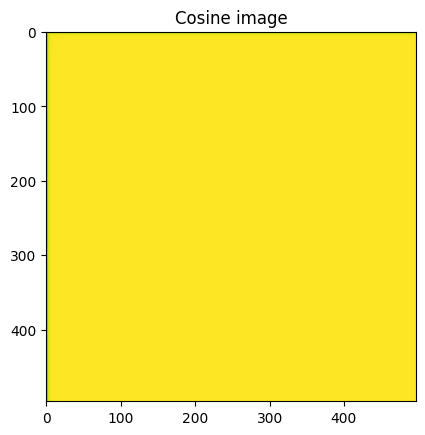

In [22]:
#print(tfidf_matrix.first)
#print(tfidf_matrix.iloc[0])

print(np.array(cosine_similarity(tfidf_matrix)[100] > 0.999948).sum())
print(np.where(np.array(cosine_similarity(tfidf_matrix)[100] > 0.999948)))
pd.DataFrame(cosine_similarity(tfidf_matrix)).head(20)

import matplotlib.pyplot as plt
img_data = cosine_similarity(tfidf_matrix)
plt.imshow(img_data)
plt.title('Cosine image')

In [77]:

# Match up similar articles in their clusters
similar = SimilarArticles(tfidf_matrix, data, 1)
similar_articles = similar.get_articles(data, 1)

1


TypeError: 'int' object is not subscriptable

In [55]:
data.head()

,Unnamed: 0.1,Unnamed: 0,name,title,url,author,content,date,old_date,preprocessed_content,cluster
0,0,0,NY Post,Jets blown out by Buffalo as Zach Wilson quest...,https://nypost.com/2023/11/19/sports/jets-blow...,Brian Costello,Δ Thanks for contacting us. We've received you...,2023-11-19 19:53:00,"Nov. 19, 2023, 7:53 p.m. ET",thank contact us weve receiv submiss orchard p...,6
1,1,1,NY Post,Cops believe torso found on NYC beach may be v...,https://nypost.com/2023/11/19/metro/torso-foun...,Joe Marino,Police believe the human torso found on a Quee...,2023-11-19 14:47:00,"Nov. 19, 2023, 2:47 p.m. ET",polic believ human torso found queen beach may...,0
2,2,2,NY Post,"NYC Council to 'roll over,' accept Mayor Eric ...",https://nypost.com/2023/11/19/metro/nyc-counci...,Carl Campanile,Δ Thanks for contacting us. We've received you...,2023-11-19 20:11:00,"Nov. 19, 2023, 8:11 p.m. ET",thank contact us weve receiv submiss citi coun...,5
3,3,3,NY Post,"Gunman opens fire, injures 1 in broad daylight...",https://nypost.com/2023/11/19/metro/gunman-ope...,Joe Marino,A gunman opened fire and shot a man in broad d...,2023-11-19 19:58:00,"Nov. 19, 2023, 7:58 p.m. ET",gunman open fire shot man broad daylight insid...,5
4,4,4,NY Post,NBC drops lead golf analyst ahead of Hero Worl...,https://nypost.com/2023/11/19/sports/nbc-golf-...,Bridget Reilly,Δ Thanks for contacting us. We've received you...,2023-11-19 17:37:00,"Nov. 19, 2023, 5:37 p.m. ET",thank contact us weve receiv submiss paul azin...,5


In [48]:
print(similar)

***
New data Vidisha

In [145]:
data = pd.read_csv('data/Monday_new_scraping_data_filtered.csv')

In [152]:
new_data = data.drop(columns=['soup'])
new_data.head()

new_data.to_csv("test.csv")

#print(data.iloc[0]['soup'])